In [157]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import r2_score
from datetime import date, datetime
from sklearn.pipeline import FeatureUnion, Pipeline 
import numpy as np
from catboost import CatBoostRegressor,  Pool, cv
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
import matplotlib.pyplot as plt
%matplotlib inline

In [438]:
   
class MoneyPreprocessing(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, df): 
        k = 0.0001
        df.REFILL_OCT_16 = k * df.REFILL_OCT_16
        df.REFILL_NOV_16 = k * df.REFILL_NOV_16
        
        return df
    
    
    class ParseDate(BaseEstimator, TransformerMixin):
    today = datetime(2016,11,1)
    
    def fit(self, x, y=None):
        return self
    
    def calculate_age(self, born):    
        return (self.today - born)/np.timedelta64(1,'Y')

    def calculate_months(self, beg):
        return (self.today - beg)/np.timedelta64(1,'M')
    
    
    def transform(self, df):
        age = []
        usage = []
        
        for entry in range(len(df)):
            usage.append(int(self.calculate_months(pd.to_datetime(df.ACT_DATE[entry]))))
            age.append(self.calculate_age(pd.to_datetime(df.BIRTHDAY[entry])))
        
        age = pd.Series(age)
        usage = pd.Series(usage)
        age = (age.fillna(age.mean())).astype(dtype=np.int64)

        df['AGE'] = age
        df['DURATION_M'] = usage
        
        return df
    

class DeleteColumns(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, df):        
        col = ['ACT_DATE', 'USER_ID', 'BIRTHDAY', 'PORTED_OUT', 'STATUS', 'DEVICE_TYPE_BUS', 
               'GENDER', 'OFFER_GROUP', 'START_PACK', 'MLLS_STATE', 'TP_ISACTIVE', 
               'TP_CURRENT', 'ACTIVITY', 'USAGE_AREA', 'ASSET_TYPE_LAST', 'START_PACK', 'OFFER_GROUP']
        
        df = df.drop(col, axis=1)        
        
        return df
    
    
class FillNan(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    

    def transform(self, df):        
        num_col=['OBLIG_NUM', 'REFILL_OCT_16', 'REFILL_NOV_16', 'OUTGOING_OCT_16', 
             'OUTGOING_NOV_16', 'GPRS_OCT_16', 'GPRS_NOV_16', 'REVENUE_OCT_16', 'REVENUE_NOV_16']
        
        str_col = ['MLLS_STATE', 'USAGE_AREA', 'ASSET_TYPE_LAST']
        
        for c in num_col:
            df[c] = df[c].fillna(0)
        
        for c in str_col:
            df[c] = df[c].fillna('Undefined')
        
        f_outgoing_mean = 162.78
        m_outgoing_mean = 115
        border = (f_outgoing_mean + m_outgoing_mean)/2


        for entry in range(len(df)):
            if pd.isnull(df['GENDER'][entry]):
                df['GENDER'][entry] = 'F' if (df['OUTGOING_OCT_16'][entry]+ 
                                                  df['OUTGOING_NOV_16'][entry])/2 > border else 'M'

        #df = self.fill_gender(df)   
        return df

    
    
class DetermineActivity(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self

    def transform(self, df):        
        k = 0.2
        octmean = df.REVENUE_OCT_16.mean()
        novmean = df.REVENUE_NOV_16.mean()
        activity = []

        for entry in range(len(df)):
            if (df.REVENUE_OCT_16[entry] >= octmean*k)&(df.REVENUE_NOV_16[entry] >= octmean*k):
                activity.append('Active')
            elif (df.REVENUE_OCT_16[entry] == 0)&(df.REVENUE_NOV_16[entry] == 0):
                activity.append('Inactive')
            else:
                activity.append('Weakly active')

        df['ACTIVITY'] = pd.Series(activity)  
        pt = df.pivot_table(values='ACTIVITY',
                    columns='TP_CURRENT',
                    aggfunc=lambda x: x.mode().iat[0])

        k = []
        v = []
        for item in pt:
            k.append(item)

        for item in pt.iloc[0]:
            v.append(item)
        d = dict(zip(k, v)) 

        TP_ACTIVE = []
        for entry in df.TP_CURRENT:   
            TP_ACTIVE.append(d[entry])

        df['TP_ISACTIVE'] = pd.Series(TP_ACTIVE)
        
        return df


class PreprocessingEncode(BaseEstimator, TransformerMixin):

    def fit(self, x, y=None):
        return self

    def label_encode(self, df):
        level_map_act = {'Active' : 2, 
                         'Inactive' : 1, 
                         'Weakly active' : 0}
        
        df['TP_ISACTIVE'] = df['TP_ISACTIVE'].map(level_map_act) 
        df['ACTIVITY'] = df['ACTIVITY'].map(level_map_act) 
        
        level_map_mlls = {'Active' : 2, 
                          'Begin' : 1, 
                          'Deleted' : 0, 
                          'Undefined' : 0}
        
        df['MLLS_STATE'] = df['MLLS_STATE'].map(level_map_mlls)  
        
        return df
    
    
    def transform(self, df):
        ohe_col = ['GENDER', 'USAGE_AREA', 'ASSET_TYPE_LAST']
        le_col = ['TP_ISACTIVE', 'MLLS_STATE', 'ACTIVE']
        OHE = OneHotEncoder(sparse=False, handle_unknown='ignore')
        
        for c in ohe_col:  
            df1 = pd.DataFrame(OHE.fit_transform(df[[c]]),
                               columns = [c + str(i) for i in range(len(df[c].value_counts()))])
            
            df1.iloc[:, 0] = df1.iloc[:, 0].astype('bool')
            df1.iloc[:, 1] = df1.iloc[:, 1].astype('bool')

            df = df.join(df1)
            
        df = self.label_encode(df)

        return df

    
class CatBoost(BaseEstimator, TransformerMixin):

    def fit(self, x, y=None):
        return self
    
    
    def predict(self, df):
        cat = CatBoostRegressor(learning_rate=0.03, depth=6, l2_leaf_reg=5)
        cat.fit(X_train, y_train)
        r2_score(y_test, cat.predict(X_test))
        cross_val_score(estimator=cat, X=X_train, y=y_train, 
                        cv=KFold(5, shuffle=True, random_state=42), scoring='r2').mean()
        return cat.predict(X_test)

In [439]:
df = pd.read_csv('train.csv',sep = ';')
pd.set_option('display.max_columns', 500)
df

,USER_ID,ACT_DATE,STATUS,TP_CURRENT,TP_CHANGES_NUM,START_PACK,OFFER_GROUP,BIRTHDAY,GENDER,MLLS_STATE,PORTED_IN,PORTED_OUT,OBLIG_NUM,OBLIG_ON_START,ASSET_TYPE_LAST,DEVICE_TYPE_BUS,USAGE_AREA,REFILL_OCT_16,REFILL_NOV_16,OUTGOING_OCT_16,OUTGOING_NOV_16,GPRS_OCT_16,GPRS_NOV_16,REVENUE_OCT_16,REVENUE_NOV_16,ACTIVITY_DEC_16
0,6925431,2012-06-21,D,TP_STATE,0.0,NaN,NaN,1988-04-12,M,NaN,False,False,NaN,False,NaN,Undefined,NaN,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00,0
1,8027797,2013-11-05,D,TP_DL012,20.0,Commercial,Standard,1984-01-02,M,Active,False,False,NaN,False,NaN,Smartphone,Minsk,150000.0,90000.0,337.433333,821.266667,2319.0,2896.0,14.171355,9.75,1
2,23498773,2015-07-17,D,TP_L,0.0,Commercial,Promo,1996-09-09,M,Active,False,False,NaN,False,NaN,Smartphone,Minsk,180000.0,100000.0,396.033333,145.466667,80369.0,15803.0,16.170000,10.74,1
3,7039091,2012-08-02,D,TP_DL012,1.0,Commercial,Standard,NaN,M,NaN,False,False,NaN,False,NaN,Smartphone,Regional Cities,100000.0,80000.0,234.900000,306.283333,1155.0,1695.0,8.780000,9.42,1
4,7510978,2013-03-06,D,TP_ANDR,0.0,NaN,NaN,1991-03-16,F,Active,False,False,NaN,False,Smartphone,Undefined,NaN,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29203,24582357,2016-04-18,D,TP_3GM,0.0,Commercial,Promo,1982-01-05,F,NaN,False,False,1.0,True,Modem (3G),Modem/Router,Minsk,100000.0,100000.0,0.000000,0.000000,7190.0,6476.0,9.900000,9.90,1
29204,22868541,2015-01-10,D,TP_S,1.0,Commercial,Standard,1978-08-13,M,NaN,False,False,NaN,False,NaN,Smartphone,Local Towns,60000.0,0.0,174.416667,138.083333,542.0,370.0,6.100000,0.00,1
29205,22746252,2014-12-04,D,TP_STP,0.0,Commercial,Standard,1979-07-02,M,NaN,False,False,1.0,True,Smartphone,Smartphone,Mix,190000.0,140000.0,67.183333,80.100000,6423.0,9195.0,19.180000,14.87,1
29206,24917373,2016-07-28,D,TP_XXL,0.0,Commercial,Promo,1995-07-19,M,NaN,False,False,NaN,False,NaN,Smartphone,Local Towns,0.0,130000.0,61.000000,166.583333,167.0,488.0,0.000000,13.50,1


In [441]:

pipeline = Pipeline(steps = [ ( 'fill', FillNan()),
                              ('activity', DetermineActivity()),
                              ('date', ParseDate()),
                              ( 'encode', PreprocessingEncode()),
                              ('money', MoneyPreprocessing()),
                             ('delete', DeleteColumns())] )

pipeline.fit(df)
df = pipeline.transform(df)


In [282]:
y = df['ACTIVITY_DEC_16']
df.drop(['ACTIVITY_DEC_16'], axis=1, inplace=True)
X = df.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)


In [361]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1, random_state=42, max_leaf_nodes=10), n_estimators=180,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=10,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=42,
                                 

In [358]:
pr = ada_clf.predict(X_train)

In [359]:
r2_score(y_test, ada_clf.predict(X_test))

0.6237177467062525

In [325]:
# param_grid = {"learning_rate" : np.linspace(0.02,0.75,3),
#               "n_estimators": np.linspace[180, 200, 20]
#              }
             
# grid_search = GridSearchCV(estimator=ada_clf, cv=10, param_grid=param_grid, n_jobs=1)
# grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [415]:
gb_clf = GradientBoostingClassifier(learning_rate=0.1, subsample=0.5, max_depth=2, n_estimators=180, random_state=42)

gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=180,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
# param_grid = {"learning_rate" : np.linspace(0.02,0.75,3),
#               "n_estimators": np.linspace[180, 200, 20]
#              }
             
# grid_search = GridSearchCV(estimator=gb_clf, cv=10, param_grid=param_grid, n_jobs=1)
# grid_search.fit(X_train, y_train)

In [416]:
r2_score(y_test, gb_clf.predict(X_test))

0.6463269808097395

In [436]:
df

array([0.0173169 , 0.86893708, 1.00182408, ..., 0.99735754, 0.41187562,
       0.99423536])

In [447]:
cat = CatBoostRegressor(learning_rate=0.03, depth=6, l2_leaf_reg=5)
cat.fit(X_train, y_train)

0:	learn: 0.4514268	total: 4.2ms	remaining: 4.19s
1:	learn: 0.4420928	total: 8.1ms	remaining: 4.04s
2:	learn: 0.4331536	total: 12ms	remaining: 4s
3:	learn: 0.4245242	total: 15.8ms	remaining: 3.94s
4:	learn: 0.4162268	total: 19.5ms	remaining: 3.89s
5:	learn: 0.4082385	total: 23.4ms	remaining: 3.87s
6:	learn: 0.4003816	total: 27.4ms	remaining: 3.88s
7:	learn: 0.3929740	total: 31.4ms	remaining: 3.89s
8:	learn: 0.3858587	total: 35.4ms	remaining: 3.9s
9:	learn: 0.3790183	total: 39.5ms	remaining: 3.91s
10:	learn: 0.3725644	total: 43.3ms	remaining: 3.89s
11:	learn: 0.3663615	total: 47ms	remaining: 3.87s
12:	learn: 0.3604891	total: 50.7ms	remaining: 3.85s
13:	learn: 0.3547406	total: 54.5ms	remaining: 3.84s
14:	learn: 0.3491922	total: 58.4ms	remaining: 3.83s
15:	learn: 0.3440044	total: 62.1ms	remaining: 3.82s
16:	learn: 0.3391644	total: 65.8ms	remaining: 3.8s
17:	learn: 0.3344639	total: 69.5ms	remaining: 3.79s
18:	learn: 0.3297977	total: 73.4ms	remaining: 3.79s
19:	learn: 0.3253055	total: 77.2m

169:	learn: 0.2318139	total: 694ms	remaining: 3.38s
170:	learn: 0.2317870	total: 697ms	remaining: 3.38s
171:	learn: 0.2317659	total: 701ms	remaining: 3.37s
172:	learn: 0.2317408	total: 705ms	remaining: 3.37s
173:	learn: 0.2317168	total: 709ms	remaining: 3.37s
174:	learn: 0.2317078	total: 713ms	remaining: 3.36s
175:	learn: 0.2316927	total: 721ms	remaining: 3.37s
176:	learn: 0.2316625	total: 725ms	remaining: 3.37s
177:	learn: 0.2316424	total: 729ms	remaining: 3.37s
178:	learn: 0.2316159	total: 733ms	remaining: 3.36s
179:	learn: 0.2316060	total: 737ms	remaining: 3.36s
180:	learn: 0.2315910	total: 741ms	remaining: 3.35s
181:	learn: 0.2315652	total: 744ms	remaining: 3.35s
182:	learn: 0.2315465	total: 748ms	remaining: 3.34s
183:	learn: 0.2315325	total: 752ms	remaining: 3.33s
184:	learn: 0.2315123	total: 756ms	remaining: 3.33s
185:	learn: 0.2315057	total: 759ms	remaining: 3.32s
186:	learn: 0.2314892	total: 763ms	remaining: 3.32s
187:	learn: 0.2314819	total: 767ms	remaining: 3.31s
188:	learn: 

342:	learn: 0.2285733	total: 1.39s	remaining: 2.66s
343:	learn: 0.2285365	total: 1.39s	remaining: 2.65s
344:	learn: 0.2285183	total: 1.4s	remaining: 2.65s
345:	learn: 0.2285137	total: 1.4s	remaining: 2.65s
346:	learn: 0.2284950	total: 1.4s	remaining: 2.64s
347:	learn: 0.2284907	total: 1.41s	remaining: 2.64s
348:	learn: 0.2284857	total: 1.41s	remaining: 2.63s
349:	learn: 0.2284452	total: 1.42s	remaining: 2.63s
350:	learn: 0.2284406	total: 1.42s	remaining: 2.63s
351:	learn: 0.2284379	total: 1.43s	remaining: 2.62s
352:	learn: 0.2284292	total: 1.43s	remaining: 2.62s
353:	learn: 0.2284274	total: 1.43s	remaining: 2.62s
354:	learn: 0.2284247	total: 1.44s	remaining: 2.61s
355:	learn: 0.2284224	total: 1.44s	remaining: 2.61s
356:	learn: 0.2283973	total: 1.45s	remaining: 2.61s
357:	learn: 0.2283596	total: 1.45s	remaining: 2.6s
358:	learn: 0.2283583	total: 1.45s	remaining: 2.6s
359:	learn: 0.2283433	total: 1.46s	remaining: 2.59s
360:	learn: 0.2283320	total: 1.46s	remaining: 2.59s
361:	learn: 0.228

509:	learn: 0.2265475	total: 2.08s	remaining: 2s
510:	learn: 0.2265334	total: 2.08s	remaining: 1.99s
511:	learn: 0.2265325	total: 2.09s	remaining: 1.99s
512:	learn: 0.2265316	total: 2.1s	remaining: 1.99s
513:	learn: 0.2265200	total: 2.1s	remaining: 1.99s
514:	learn: 0.2264998	total: 2.11s	remaining: 1.98s
515:	learn: 0.2264709	total: 2.11s	remaining: 1.98s
516:	learn: 0.2264684	total: 2.12s	remaining: 1.98s
517:	learn: 0.2264509	total: 2.12s	remaining: 1.97s
518:	learn: 0.2264320	total: 2.13s	remaining: 1.97s
519:	learn: 0.2264044	total: 2.13s	remaining: 1.97s
520:	learn: 0.2263900	total: 2.13s	remaining: 1.96s
521:	learn: 0.2263774	total: 2.14s	remaining: 1.96s
522:	learn: 0.2263566	total: 2.15s	remaining: 1.96s
523:	learn: 0.2263125	total: 2.15s	remaining: 1.95s
524:	learn: 0.2263020	total: 2.15s	remaining: 1.95s
525:	learn: 0.2263011	total: 2.16s	remaining: 1.95s
526:	learn: 0.2262557	total: 2.16s	remaining: 1.94s
527:	learn: 0.2262548	total: 2.17s	remaining: 1.94s
528:	learn: 0.226

676:	learn: 0.2240450	total: 2.77s	remaining: 1.32s
677:	learn: 0.2240444	total: 2.77s	remaining: 1.32s
678:	learn: 0.2240229	total: 2.77s	remaining: 1.31s
679:	learn: 0.2240094	total: 2.78s	remaining: 1.31s
680:	learn: 0.2240089	total: 2.78s	remaining: 1.3s
681:	learn: 0.2239901	total: 2.79s	remaining: 1.3s
682:	learn: 0.2239895	total: 2.79s	remaining: 1.29s
683:	learn: 0.2239725	total: 2.79s	remaining: 1.29s
684:	learn: 0.2239548	total: 2.8s	remaining: 1.29s
685:	learn: 0.2239511	total: 2.8s	remaining: 1.28s
686:	learn: 0.2239300	total: 2.81s	remaining: 1.28s
687:	learn: 0.2239225	total: 2.81s	remaining: 1.27s
688:	learn: 0.2239148	total: 2.81s	remaining: 1.27s
689:	learn: 0.2238901	total: 2.82s	remaining: 1.27s
690:	learn: 0.2238722	total: 2.82s	remaining: 1.26s
691:	learn: 0.2238712	total: 2.83s	remaining: 1.26s
692:	learn: 0.2238571	total: 2.83s	remaining: 1.25s
693:	learn: 0.2238417	total: 2.83s	remaining: 1.25s
694:	learn: 0.2238391	total: 2.84s	remaining: 1.25s
695:	learn: 0.22

855:	learn: 0.2218360	total: 3.46s	remaining: 583ms
856:	learn: 0.2218328	total: 3.47s	remaining: 579ms
857:	learn: 0.2218212	total: 3.47s	remaining: 575ms
858:	learn: 0.2217999	total: 3.48s	remaining: 571ms
859:	learn: 0.2217983	total: 3.48s	remaining: 567ms
860:	learn: 0.2217858	total: 3.48s	remaining: 563ms
861:	learn: 0.2217772	total: 3.49s	remaining: 559ms
862:	learn: 0.2217546	total: 3.49s	remaining: 554ms
863:	learn: 0.2217442	total: 3.5s	remaining: 550ms
864:	learn: 0.2217267	total: 3.5s	remaining: 546ms
865:	learn: 0.2216962	total: 3.5s	remaining: 542ms
866:	learn: 0.2216937	total: 3.51s	remaining: 538ms
867:	learn: 0.2216897	total: 3.51s	remaining: 534ms
868:	learn: 0.2216790	total: 3.52s	remaining: 530ms
869:	learn: 0.2216699	total: 3.52s	remaining: 526ms
870:	learn: 0.2216480	total: 3.52s	remaining: 522ms
871:	learn: 0.2216330	total: 3.53s	remaining: 518ms
872:	learn: 0.2216324	total: 3.53s	remaining: 514ms
873:	learn: 0.2216317	total: 3.54s	remaining: 510ms
874:	learn: 0.2

In [448]:
# grid = {'learning_rate': np.linspace(0.01,0.1,4),
#         'depth': [4, 6],
#         'l2_leaf_reg': [1, 5, 7],
#        'model_size_reg':[0.001,0.01,0.02, 0.07]}

# grid_search_result = cat.grid_search(grid, 
#                                        X=X_train, 
#                                        y=y_train, 
#                                        plot=True)

In [449]:
r2_score(y_test, cat.predict(X_test))

0.7433031847395934

In [450]:
cross_val_score(estimator=cat, X=X_train, y=y_train, cv=KFold(5, shuffle=True, random_state=42), scoring='r2').mean()

0:	learn: 0.4504479	total: 12.6ms	remaining: 12.6s
1:	learn: 0.4412579	total: 16.2ms	remaining: 8.09s
2:	learn: 0.4323780	total: 19.7ms	remaining: 6.55s
3:	learn: 0.4237872	total: 23.3ms	remaining: 5.8s
4:	learn: 0.4155466	total: 27ms	remaining: 5.37s
5:	learn: 0.4076140	total: 30.6ms	remaining: 5.07s
6:	learn: 0.3998864	total: 34.2ms	remaining: 4.85s
7:	learn: 0.3925071	total: 37.5ms	remaining: 4.65s
8:	learn: 0.3854373	total: 41.4ms	remaining: 4.56s
9:	learn: 0.3786933	total: 44.8ms	remaining: 4.44s
10:	learn: 0.3722969	total: 48.3ms	remaining: 4.34s
11:	learn: 0.3661291	total: 51.6ms	remaining: 4.25s
12:	learn: 0.3602159	total: 55.1ms	remaining: 4.18s
13:	learn: 0.3544744	total: 58.5ms	remaining: 4.12s
14:	learn: 0.3489432	total: 62ms	remaining: 4.07s
15:	learn: 0.3438005	total: 65.3ms	remaining: 4.02s
16:	learn: 0.3389694	total: 68.7ms	remaining: 3.97s
17:	learn: 0.3341717	total: 72.4ms	remaining: 3.95s
18:	learn: 0.3295327	total: 75.8ms	remaining: 3.92s
19:	learn: 0.3251064	total:

189:	learn: 0.2316619	total: 705ms	remaining: 3s
190:	learn: 0.2316260	total: 708ms	remaining: 3s
191:	learn: 0.2315780	total: 712ms	remaining: 2.99s
192:	learn: 0.2315486	total: 715ms	remaining: 2.99s
193:	learn: 0.2315364	total: 719ms	remaining: 2.99s
194:	learn: 0.2314966	total: 723ms	remaining: 2.98s
195:	learn: 0.2314576	total: 727ms	remaining: 2.98s
196:	learn: 0.2314153	total: 732ms	remaining: 2.98s
197:	learn: 0.2314075	total: 736ms	remaining: 2.98s
198:	learn: 0.2313933	total: 739ms	remaining: 2.98s
199:	learn: 0.2313759	total: 743ms	remaining: 2.97s
200:	learn: 0.2313634	total: 747ms	remaining: 2.97s
201:	learn: 0.2313457	total: 751ms	remaining: 2.96s
202:	learn: 0.2313308	total: 754ms	remaining: 2.96s
203:	learn: 0.2313026	total: 758ms	remaining: 2.96s
204:	learn: 0.2312920	total: 762ms	remaining: 2.95s
205:	learn: 0.2312757	total: 765ms	remaining: 2.95s
206:	learn: 0.2312669	total: 768ms	remaining: 2.94s
207:	learn: 0.2312508	total: 772ms	remaining: 2.94s
208:	learn: 0.2312

382:	learn: 0.2280950	total: 1.39s	remaining: 2.24s
383:	learn: 0.2280934	total: 1.39s	remaining: 2.23s
384:	learn: 0.2280697	total: 1.4s	remaining: 2.23s
385:	learn: 0.2280369	total: 1.4s	remaining: 2.23s
386:	learn: 0.2279996	total: 1.41s	remaining: 2.23s
387:	learn: 0.2279979	total: 1.41s	remaining: 2.22s
388:	learn: 0.2279808	total: 1.41s	remaining: 2.22s
389:	learn: 0.2279792	total: 1.42s	remaining: 2.22s
390:	learn: 0.2279577	total: 1.42s	remaining: 2.21s
391:	learn: 0.2279286	total: 1.42s	remaining: 2.21s
392:	learn: 0.2279275	total: 1.43s	remaining: 2.21s
393:	learn: 0.2278733	total: 1.43s	remaining: 2.2s
394:	learn: 0.2278460	total: 1.44s	remaining: 2.2s
395:	learn: 0.2278446	total: 1.44s	remaining: 2.19s
396:	learn: 0.2278341	total: 1.44s	remaining: 2.19s
397:	learn: 0.2278327	total: 1.44s	remaining: 2.19s
398:	learn: 0.2278289	total: 1.45s	remaining: 2.18s
399:	learn: 0.2278249	total: 1.45s	remaining: 2.18s
400:	learn: 0.2278170	total: 1.45s	remaining: 2.17s
401:	learn: 0.22

580:	learn: 0.2248398	total: 2.08s	remaining: 1.5s
581:	learn: 0.2248292	total: 2.09s	remaining: 1.5s
582:	learn: 0.2248190	total: 2.09s	remaining: 1.49s
583:	learn: 0.2247748	total: 2.09s	remaining: 1.49s
584:	learn: 0.2247549	total: 2.1s	remaining: 1.49s
585:	learn: 0.2247260	total: 2.1s	remaining: 1.49s
586:	learn: 0.2246860	total: 2.11s	remaining: 1.48s
587:	learn: 0.2246545	total: 2.11s	remaining: 1.48s
588:	learn: 0.2246517	total: 2.12s	remaining: 1.48s
589:	learn: 0.2246431	total: 2.12s	remaining: 1.47s
590:	learn: 0.2246348	total: 2.12s	remaining: 1.47s
591:	learn: 0.2246098	total: 2.13s	remaining: 1.47s
592:	learn: 0.2245951	total: 2.13s	remaining: 1.46s
593:	learn: 0.2245712	total: 2.13s	remaining: 1.46s
594:	learn: 0.2245349	total: 2.14s	remaining: 1.46s
595:	learn: 0.2244952	total: 2.14s	remaining: 1.45s
596:	learn: 0.2244870	total: 2.15s	remaining: 1.45s
597:	learn: 0.2244712	total: 2.15s	remaining: 1.45s
598:	learn: 0.2244432	total: 2.15s	remaining: 1.44s
599:	learn: 0.22

773:	learn: 0.2217638	total: 2.77s	remaining: 809ms
774:	learn: 0.2217618	total: 2.77s	remaining: 805ms
775:	learn: 0.2217507	total: 2.78s	remaining: 801ms
776:	learn: 0.2217471	total: 2.78s	remaining: 798ms
777:	learn: 0.2217268	total: 2.78s	remaining: 794ms
778:	learn: 0.2217162	total: 2.79s	remaining: 791ms
779:	learn: 0.2216779	total: 2.79s	remaining: 788ms
780:	learn: 0.2216677	total: 2.79s	remaining: 784ms
781:	learn: 0.2216302	total: 2.8s	remaining: 780ms
782:	learn: 0.2216281	total: 2.8s	remaining: 777ms
783:	learn: 0.2216271	total: 2.81s	remaining: 773ms
784:	learn: 0.2216210	total: 2.81s	remaining: 769ms
785:	learn: 0.2215867	total: 2.81s	remaining: 766ms
786:	learn: 0.2215650	total: 2.82s	remaining: 762ms
787:	learn: 0.2215525	total: 2.82s	remaining: 759ms
788:	learn: 0.2215489	total: 2.82s	remaining: 755ms
789:	learn: 0.2215454	total: 2.83s	remaining: 751ms
790:	learn: 0.2215446	total: 2.83s	remaining: 748ms
791:	learn: 0.2215105	total: 2.83s	remaining: 744ms
792:	learn: 0.

970:	learn: 0.2186618	total: 3.46s	remaining: 103ms
971:	learn: 0.2186334	total: 3.47s	remaining: 99.9ms
972:	learn: 0.2186172	total: 3.47s	remaining: 96.3ms
973:	learn: 0.2185966	total: 3.47s	remaining: 92.7ms
974:	learn: 0.2185834	total: 3.48s	remaining: 89.2ms
975:	learn: 0.2185623	total: 3.48s	remaining: 85.6ms
976:	learn: 0.2185496	total: 3.49s	remaining: 82.1ms
977:	learn: 0.2185416	total: 3.49s	remaining: 78.5ms
978:	learn: 0.2185321	total: 3.49s	remaining: 74.9ms
979:	learn: 0.2185308	total: 3.5s	remaining: 71.4ms
980:	learn: 0.2185105	total: 3.5s	remaining: 67.8ms
981:	learn: 0.2185071	total: 3.5s	remaining: 64.2ms
982:	learn: 0.2185056	total: 3.51s	remaining: 60.6ms
983:	learn: 0.2184807	total: 3.51s	remaining: 57.1ms
984:	learn: 0.2184799	total: 3.51s	remaining: 53.5ms
985:	learn: 0.2184440	total: 3.52s	remaining: 49.9ms
986:	learn: 0.2184223	total: 3.52s	remaining: 46.4ms
987:	learn: 0.2184141	total: 3.52s	remaining: 42.8ms
988:	learn: 0.2183983	total: 3.53s	remaining: 39.2

142:	learn: 0.2307278	total: 525ms	remaining: 3.15s
143:	learn: 0.2306753	total: 529ms	remaining: 3.15s
144:	learn: 0.2306235	total: 533ms	remaining: 3.14s
145:	learn: 0.2305956	total: 537ms	remaining: 3.14s
146:	learn: 0.2305506	total: 541ms	remaining: 3.14s
147:	learn: 0.2304947	total: 544ms	remaining: 3.13s
148:	learn: 0.2304494	total: 549ms	remaining: 3.13s
149:	learn: 0.2303984	total: 552ms	remaining: 3.13s
150:	learn: 0.2303004	total: 556ms	remaining: 3.12s
151:	learn: 0.2302633	total: 559ms	remaining: 3.12s
152:	learn: 0.2302056	total: 564ms	remaining: 3.12s
153:	learn: 0.2301781	total: 567ms	remaining: 3.12s
154:	learn: 0.2301483	total: 571ms	remaining: 3.11s
155:	learn: 0.2301228	total: 574ms	remaining: 3.1s
156:	learn: 0.2300633	total: 578ms	remaining: 3.1s
157:	learn: 0.2300366	total: 581ms	remaining: 3.1s
158:	learn: 0.2300034	total: 585ms	remaining: 3.09s
159:	learn: 0.2299725	total: 588ms	remaining: 3.09s
160:	learn: 0.2299069	total: 592ms	remaining: 3.08s
161:	learn: 0.2

334:	learn: 0.2254331	total: 1.22s	remaining: 2.41s
335:	learn: 0.2254185	total: 1.22s	remaining: 2.41s
336:	learn: 0.2254180	total: 1.22s	remaining: 2.41s
337:	learn: 0.2254132	total: 1.23s	remaining: 2.4s
338:	learn: 0.2253861	total: 1.23s	remaining: 2.4s
339:	learn: 0.2253780	total: 1.24s	remaining: 2.4s
340:	learn: 0.2253671	total: 1.24s	remaining: 2.4s
341:	learn: 0.2253507	total: 1.24s	remaining: 2.39s
342:	learn: 0.2253367	total: 1.25s	remaining: 2.39s
343:	learn: 0.2253247	total: 1.25s	remaining: 2.38s
344:	learn: 0.2252886	total: 1.25s	remaining: 2.38s
345:	learn: 0.2252860	total: 1.26s	remaining: 2.38s
346:	learn: 0.2252579	total: 1.26s	remaining: 2.37s
347:	learn: 0.2252224	total: 1.26s	remaining: 2.37s
348:	learn: 0.2252205	total: 1.27s	remaining: 2.37s
349:	learn: 0.2252003	total: 1.27s	remaining: 2.36s
350:	learn: 0.2251931	total: 1.27s	remaining: 2.36s
351:	learn: 0.2251579	total: 1.28s	remaining: 2.35s
352:	learn: 0.2251377	total: 1.28s	remaining: 2.35s
353:	learn: 0.22

531:	learn: 0.2229531	total: 1.91s	remaining: 1.68s
532:	learn: 0.2229525	total: 1.91s	remaining: 1.68s
533:	learn: 0.2229234	total: 1.92s	remaining: 1.67s
534:	learn: 0.2229037	total: 1.92s	remaining: 1.67s
535:	learn: 0.2229013	total: 1.93s	remaining: 1.67s
536:	learn: 0.2229007	total: 1.93s	remaining: 1.66s
537:	learn: 0.2228746	total: 1.93s	remaining: 1.66s
538:	learn: 0.2228523	total: 1.94s	remaining: 1.66s
539:	learn: 0.2228518	total: 1.94s	remaining: 1.65s
540:	learn: 0.2228513	total: 1.94s	remaining: 1.65s
541:	learn: 0.2228363	total: 1.95s	remaining: 1.64s
542:	learn: 0.2228251	total: 1.95s	remaining: 1.64s
543:	learn: 0.2227797	total: 1.95s	remaining: 1.64s
544:	learn: 0.2227791	total: 1.96s	remaining: 1.63s
545:	learn: 0.2227769	total: 1.96s	remaining: 1.63s
546:	learn: 0.2227590	total: 1.96s	remaining: 1.63s
547:	learn: 0.2227585	total: 1.97s	remaining: 1.62s
548:	learn: 0.2227362	total: 1.97s	remaining: 1.62s
549:	learn: 0.2227179	total: 1.97s	remaining: 1.61s
550:	learn: 

706:	learn: 0.2198274	total: 2.61s	remaining: 1.08s
707:	learn: 0.2198000	total: 2.61s	remaining: 1.08s
708:	learn: 0.2197833	total: 2.62s	remaining: 1.07s
709:	learn: 0.2197710	total: 2.62s	remaining: 1.07s
710:	learn: 0.2197540	total: 2.62s	remaining: 1.07s
711:	learn: 0.2197495	total: 2.63s	remaining: 1.06s
712:	learn: 0.2197474	total: 2.63s	remaining: 1.06s
713:	learn: 0.2197263	total: 2.64s	remaining: 1.06s
714:	learn: 0.2197030	total: 2.64s	remaining: 1.05s
715:	learn: 0.2196837	total: 2.65s	remaining: 1.05s
716:	learn: 0.2196460	total: 2.65s	remaining: 1.05s
717:	learn: 0.2196274	total: 2.65s	remaining: 1.04s
718:	learn: 0.2195958	total: 2.66s	remaining: 1.04s
719:	learn: 0.2195661	total: 2.66s	remaining: 1.03s
720:	learn: 0.2195370	total: 2.67s	remaining: 1.03s
721:	learn: 0.2195013	total: 2.67s	remaining: 1.03s
722:	learn: 0.2194993	total: 2.67s	remaining: 1.02s
723:	learn: 0.2194717	total: 2.68s	remaining: 1.02s
724:	learn: 0.2194613	total: 2.68s	remaining: 1.02s
725:	learn: 

881:	learn: 0.2168470	total: 3.29s	remaining: 441ms
882:	learn: 0.2168421	total: 3.3s	remaining: 437ms
883:	learn: 0.2168259	total: 3.3s	remaining: 433ms
884:	learn: 0.2168106	total: 3.31s	remaining: 430ms
885:	learn: 0.2167824	total: 3.31s	remaining: 426ms
886:	learn: 0.2167686	total: 3.32s	remaining: 422ms
887:	learn: 0.2167662	total: 3.32s	remaining: 419ms
888:	learn: 0.2167638	total: 3.32s	remaining: 415ms
889:	learn: 0.2167413	total: 3.33s	remaining: 411ms
890:	learn: 0.2167340	total: 3.33s	remaining: 408ms
891:	learn: 0.2167287	total: 3.33s	remaining: 404ms
892:	learn: 0.2167278	total: 3.34s	remaining: 400ms
893:	learn: 0.2167255	total: 3.34s	remaining: 397ms
894:	learn: 0.2167141	total: 3.35s	remaining: 393ms
895:	learn: 0.2166980	total: 3.35s	remaining: 389ms
896:	learn: 0.2166707	total: 3.36s	remaining: 386ms
897:	learn: 0.2166673	total: 3.36s	remaining: 382ms
898:	learn: 0.2166455	total: 3.36s	remaining: 378ms
899:	learn: 0.2166282	total: 3.37s	remaining: 374ms
900:	learn: 0.

47:	learn: 0.2567001	total: 194ms	remaining: 3.85s
48:	learn: 0.2556010	total: 198ms	remaining: 3.84s
49:	learn: 0.2544631	total: 204ms	remaining: 3.87s
50:	learn: 0.2534205	total: 209ms	remaining: 3.88s
51:	learn: 0.2524396	total: 213ms	remaining: 3.88s
52:	learn: 0.2515903	total: 220ms	remaining: 3.93s
53:	learn: 0.2507188	total: 224ms	remaining: 3.92s
54:	learn: 0.2498611	total: 228ms	remaining: 3.92s
55:	learn: 0.2490003	total: 234ms	remaining: 3.95s
56:	learn: 0.2482770	total: 238ms	remaining: 3.94s
57:	learn: 0.2476025	total: 242ms	remaining: 3.93s
58:	learn: 0.2469087	total: 249ms	remaining: 3.97s
59:	learn: 0.2462392	total: 254ms	remaining: 3.98s
60:	learn: 0.2456476	total: 259ms	remaining: 3.99s
61:	learn: 0.2450725	total: 266ms	remaining: 4.02s
62:	learn: 0.2445059	total: 270ms	remaining: 4.01s
63:	learn: 0.2440377	total: 274ms	remaining: 4.01s
64:	learn: 0.2435183	total: 279ms	remaining: 4.01s
65:	learn: 0.2429802	total: 283ms	remaining: 4.01s
66:	learn: 0.2425482	total: 287

213:	learn: 0.2295646	total: 882ms	remaining: 3.24s
214:	learn: 0.2295402	total: 886ms	remaining: 3.23s
215:	learn: 0.2295152	total: 892ms	remaining: 3.24s
216:	learn: 0.2294834	total: 896ms	remaining: 3.23s
217:	learn: 0.2294606	total: 901ms	remaining: 3.23s
218:	learn: 0.2294291	total: 906ms	remaining: 3.23s
219:	learn: 0.2293867	total: 910ms	remaining: 3.23s
220:	learn: 0.2293526	total: 913ms	remaining: 3.22s
221:	learn: 0.2293346	total: 917ms	remaining: 3.21s
222:	learn: 0.2293265	total: 922ms	remaining: 3.21s
223:	learn: 0.2293234	total: 925ms	remaining: 3.2s
224:	learn: 0.2293087	total: 929ms	remaining: 3.2s
225:	learn: 0.2292996	total: 932ms	remaining: 3.19s
226:	learn: 0.2292892	total: 937ms	remaining: 3.19s
227:	learn: 0.2292533	total: 941ms	remaining: 3.19s
228:	learn: 0.2292298	total: 945ms	remaining: 3.18s
229:	learn: 0.2292189	total: 950ms	remaining: 3.18s
230:	learn: 0.2291945	total: 954ms	remaining: 3.18s
231:	learn: 0.2291876	total: 957ms	remaining: 3.17s
232:	learn: 0.

378:	learn: 0.2265388	total: 1.56s	remaining: 2.56s
379:	learn: 0.2265377	total: 1.57s	remaining: 2.56s
380:	learn: 0.2265364	total: 1.57s	remaining: 2.55s
381:	learn: 0.2265080	total: 1.58s	remaining: 2.55s
382:	learn: 0.2265046	total: 1.58s	remaining: 2.55s
383:	learn: 0.2264964	total: 1.58s	remaining: 2.54s
384:	learn: 0.2264933	total: 1.59s	remaining: 2.54s
385:	learn: 0.2264917	total: 1.59s	remaining: 2.53s
386:	learn: 0.2264895	total: 1.6s	remaining: 2.53s
387:	learn: 0.2264872	total: 1.6s	remaining: 2.52s
388:	learn: 0.2264810	total: 1.6s	remaining: 2.52s
389:	learn: 0.2264566	total: 1.61s	remaining: 2.51s
390:	learn: 0.2264546	total: 1.61s	remaining: 2.51s
391:	learn: 0.2264532	total: 1.61s	remaining: 2.5s
392:	learn: 0.2264522	total: 1.62s	remaining: 2.5s
393:	learn: 0.2264499	total: 1.62s	remaining: 2.49s
394:	learn: 0.2264329	total: 1.62s	remaining: 2.49s
395:	learn: 0.2264312	total: 1.63s	remaining: 2.48s
396:	learn: 0.2264301	total: 1.63s	remaining: 2.48s
397:	learn: 0.226

559:	learn: 0.2237302	total: 2.25s	remaining: 1.77s
560:	learn: 0.2236938	total: 2.25s	remaining: 1.76s
561:	learn: 0.2236767	total: 2.26s	remaining: 1.76s
562:	learn: 0.2236545	total: 2.26s	remaining: 1.76s
563:	learn: 0.2236309	total: 2.27s	remaining: 1.75s
564:	learn: 0.2236035	total: 2.27s	remaining: 1.75s
565:	learn: 0.2235700	total: 2.27s	remaining: 1.74s
566:	learn: 0.2235429	total: 2.28s	remaining: 1.74s
567:	learn: 0.2235215	total: 2.28s	remaining: 1.74s
568:	learn: 0.2235060	total: 2.29s	remaining: 1.73s
569:	learn: 0.2234806	total: 2.29s	remaining: 1.73s
570:	learn: 0.2234448	total: 2.29s	remaining: 1.72s
571:	learn: 0.2234243	total: 2.3s	remaining: 1.72s
572:	learn: 0.2233912	total: 2.3s	remaining: 1.71s
573:	learn: 0.2233597	total: 2.3s	remaining: 1.71s
574:	learn: 0.2233528	total: 2.31s	remaining: 1.71s
575:	learn: 0.2233286	total: 2.31s	remaining: 1.7s
576:	learn: 0.2233110	total: 2.32s	remaining: 1.7s
577:	learn: 0.2232905	total: 2.32s	remaining: 1.69s
578:	learn: 0.223

729:	learn: 0.2200836	total: 2.94s	remaining: 1.09s
730:	learn: 0.2200820	total: 2.94s	remaining: 1.08s
731:	learn: 0.2200664	total: 2.94s	remaining: 1.08s
732:	learn: 0.2200461	total: 2.95s	remaining: 1.07s
733:	learn: 0.2200397	total: 2.96s	remaining: 1.07s
734:	learn: 0.2199919	total: 2.96s	remaining: 1.07s
735:	learn: 0.2199581	total: 2.96s	remaining: 1.06s
736:	learn: 0.2199443	total: 2.97s	remaining: 1.06s
737:	learn: 0.2199244	total: 2.97s	remaining: 1.05s
738:	learn: 0.2199051	total: 2.98s	remaining: 1.05s
739:	learn: 0.2198893	total: 2.98s	remaining: 1.05s
740:	learn: 0.2198756	total: 2.98s	remaining: 1.04s
741:	learn: 0.2198610	total: 2.99s	remaining: 1.04s
742:	learn: 0.2198430	total: 2.99s	remaining: 1.03s
743:	learn: 0.2198226	total: 2.99s	remaining: 1.03s
744:	learn: 0.2198014	total: 3s	remaining: 1.03s
745:	learn: 0.2197813	total: 3s	remaining: 1.02s
746:	learn: 0.2197581	total: 3s	remaining: 1.02s
747:	learn: 0.2197273	total: 3.01s	remaining: 1.01s
748:	learn: 0.2196833

892:	learn: 0.2171828	total: 3.62s	remaining: 433ms
893:	learn: 0.2171559	total: 3.62s	remaining: 429ms
894:	learn: 0.2171557	total: 3.63s	remaining: 425ms
895:	learn: 0.2171483	total: 3.63s	remaining: 422ms
896:	learn: 0.2171237	total: 3.63s	remaining: 418ms
897:	learn: 0.2170986	total: 3.64s	remaining: 413ms
898:	learn: 0.2170654	total: 3.64s	remaining: 410ms
899:	learn: 0.2170483	total: 3.65s	remaining: 406ms
900:	learn: 0.2170246	total: 3.65s	remaining: 402ms
901:	learn: 0.2170113	total: 3.66s	remaining: 398ms
902:	learn: 0.2169858	total: 3.66s	remaining: 394ms
903:	learn: 0.2169823	total: 3.67s	remaining: 390ms
904:	learn: 0.2169766	total: 3.67s	remaining: 386ms
905:	learn: 0.2169632	total: 3.68s	remaining: 382ms
906:	learn: 0.2169469	total: 3.68s	remaining: 378ms
907:	learn: 0.2169413	total: 3.69s	remaining: 373ms
908:	learn: 0.2169204	total: 3.69s	remaining: 369ms
909:	learn: 0.2168884	total: 3.69s	remaining: 365ms
910:	learn: 0.2168725	total: 3.7s	remaining: 361ms
911:	learn: 0

95:	learn: 0.2360489	total: 352ms	remaining: 3.31s
96:	learn: 0.2359288	total: 356ms	remaining: 3.31s
97:	learn: 0.2357859	total: 360ms	remaining: 3.31s
98:	learn: 0.2356456	total: 365ms	remaining: 3.32s
99:	learn: 0.2355193	total: 370ms	remaining: 3.33s
100:	learn: 0.2353767	total: 374ms	remaining: 3.33s
101:	learn: 0.2352729	total: 377ms	remaining: 3.32s
102:	learn: 0.2351431	total: 383ms	remaining: 3.33s
103:	learn: 0.2350434	total: 386ms	remaining: 3.33s
104:	learn: 0.2349653	total: 390ms	remaining: 3.33s
105:	learn: 0.2348532	total: 394ms	remaining: 3.32s
106:	learn: 0.2347557	total: 397ms	remaining: 3.32s
107:	learn: 0.2346903	total: 401ms	remaining: 3.31s
108:	learn: 0.2345811	total: 404ms	remaining: 3.3s
109:	learn: 0.2345026	total: 408ms	remaining: 3.3s
110:	learn: 0.2344011	total: 411ms	remaining: 3.29s
111:	learn: 0.2343443	total: 415ms	remaining: 3.29s
112:	learn: 0.2342609	total: 418ms	remaining: 3.28s
113:	learn: 0.2341763	total: 422ms	remaining: 3.28s
114:	learn: 0.23411

287:	learn: 0.2283362	total: 1.04s	remaining: 2.58s
288:	learn: 0.2283251	total: 1.05s	remaining: 2.57s
289:	learn: 0.2282678	total: 1.05s	remaining: 2.57s
290:	learn: 0.2282611	total: 1.05s	remaining: 2.57s
291:	learn: 0.2282473	total: 1.06s	remaining: 2.56s
292:	learn: 0.2282387	total: 1.06s	remaining: 2.56s
293:	learn: 0.2282258	total: 1.06s	remaining: 2.56s
294:	learn: 0.2282034	total: 1.07s	remaining: 2.55s
295:	learn: 0.2281796	total: 1.07s	remaining: 2.55s
296:	learn: 0.2281704	total: 1.07s	remaining: 2.55s
297:	learn: 0.2281417	total: 1.08s	remaining: 2.54s
298:	learn: 0.2281172	total: 1.08s	remaining: 2.54s
299:	learn: 0.2280722	total: 1.09s	remaining: 2.53s
300:	learn: 0.2280383	total: 1.09s	remaining: 2.53s
301:	learn: 0.2280249	total: 1.09s	remaining: 2.53s
302:	learn: 0.2280029	total: 1.1s	remaining: 2.52s
303:	learn: 0.2279715	total: 1.1s	remaining: 2.52s
304:	learn: 0.2279626	total: 1.1s	remaining: 2.52s
305:	learn: 0.2279339	total: 1.11s	remaining: 2.51s
306:	learn: 0.2

456:	learn: 0.2245100	total: 1.73s	remaining: 2.06s
457:	learn: 0.2244892	total: 1.74s	remaining: 2.05s
458:	learn: 0.2244714	total: 1.74s	remaining: 2.05s
459:	learn: 0.2244483	total: 1.74s	remaining: 2.05s
460:	learn: 0.2244242	total: 1.75s	remaining: 2.04s
461:	learn: 0.2244084	total: 1.75s	remaining: 2.04s
462:	learn: 0.2243886	total: 1.76s	remaining: 2.04s
463:	learn: 0.2243583	total: 1.76s	remaining: 2.04s
464:	learn: 0.2243214	total: 1.77s	remaining: 2.03s
465:	learn: 0.2242994	total: 1.77s	remaining: 2.03s
466:	learn: 0.2242805	total: 1.78s	remaining: 2.03s
467:	learn: 0.2242626	total: 1.78s	remaining: 2.02s
468:	learn: 0.2242415	total: 1.78s	remaining: 2.02s
469:	learn: 0.2242252	total: 1.79s	remaining: 2.02s
470:	learn: 0.2242009	total: 1.79s	remaining: 2.01s
471:	learn: 0.2241866	total: 1.8s	remaining: 2.01s
472:	learn: 0.2241845	total: 1.8s	remaining: 2.01s
473:	learn: 0.2241704	total: 1.81s	remaining: 2s
474:	learn: 0.2241474	total: 1.81s	remaining: 2s
475:	learn: 0.224121

632:	learn: 0.2213544	total: 2.56s	remaining: 1.49s
633:	learn: 0.2213044	total: 2.57s	remaining: 1.48s
634:	learn: 0.2212868	total: 2.57s	remaining: 1.48s
635:	learn: 0.2212657	total: 2.58s	remaining: 1.48s
636:	learn: 0.2212435	total: 2.58s	remaining: 1.47s
637:	learn: 0.2212141	total: 2.59s	remaining: 1.47s
638:	learn: 0.2211873	total: 2.59s	remaining: 1.47s
639:	learn: 0.2211608	total: 2.6s	remaining: 1.46s
640:	learn: 0.2211565	total: 2.6s	remaining: 1.46s
641:	learn: 0.2211484	total: 2.61s	remaining: 1.45s
642:	learn: 0.2211308	total: 2.61s	remaining: 1.45s
643:	learn: 0.2211004	total: 2.62s	remaining: 1.45s
644:	learn: 0.2210894	total: 2.62s	remaining: 1.44s
645:	learn: 0.2210569	total: 2.62s	remaining: 1.44s
646:	learn: 0.2210280	total: 2.63s	remaining: 1.43s
647:	learn: 0.2210114	total: 2.63s	remaining: 1.43s
648:	learn: 0.2210072	total: 2.64s	remaining: 1.43s
649:	learn: 0.2209963	total: 2.64s	remaining: 1.42s
650:	learn: 0.2209895	total: 2.65s	remaining: 1.42s
651:	learn: 0.

823:	learn: 0.2183589	total: 3.43s	remaining: 733ms
824:	learn: 0.2183406	total: 3.44s	remaining: 729ms
825:	learn: 0.2183235	total: 3.44s	remaining: 725ms
826:	learn: 0.2183133	total: 3.45s	remaining: 721ms
827:	learn: 0.2183117	total: 3.45s	remaining: 717ms
828:	learn: 0.2183075	total: 3.46s	remaining: 714ms
829:	learn: 0.2182810	total: 3.46s	remaining: 710ms
830:	learn: 0.2182781	total: 3.47s	remaining: 706ms
831:	learn: 0.2182523	total: 3.48s	remaining: 702ms
832:	learn: 0.2182469	total: 3.48s	remaining: 698ms
833:	learn: 0.2182448	total: 3.48s	remaining: 694ms
834:	learn: 0.2182331	total: 3.49s	remaining: 690ms
835:	learn: 0.2182317	total: 3.5s	remaining: 686ms
836:	learn: 0.2182253	total: 3.5s	remaining: 682ms
837:	learn: 0.2182056	total: 3.51s	remaining: 678ms
838:	learn: 0.2181760	total: 3.51s	remaining: 674ms
839:	learn: 0.2181745	total: 3.52s	remaining: 670ms
840:	learn: 0.2181635	total: 3.52s	remaining: 666ms
841:	learn: 0.2181619	total: 3.53s	remaining: 662ms
842:	learn: 0.

990:	learn: 0.2159993	total: 4.29s	remaining: 39ms
991:	learn: 0.2159982	total: 4.29s	remaining: 34.6ms
992:	learn: 0.2159968	total: 4.3s	remaining: 30.3ms
993:	learn: 0.2159946	total: 4.31s	remaining: 26ms
994:	learn: 0.2159931	total: 4.31s	remaining: 21.7ms
995:	learn: 0.2159728	total: 4.33s	remaining: 17.4ms
996:	learn: 0.2159717	total: 4.33s	remaining: 13ms
997:	learn: 0.2159578	total: 4.34s	remaining: 8.69ms
998:	learn: 0.2159369	total: 4.34s	remaining: 4.35ms
999:	learn: 0.2159361	total: 4.35s	remaining: 0us
0:	learn: 0.4524822	total: 3.89ms	remaining: 3.89s
1:	learn: 0.4431870	total: 8.07ms	remaining: 4.03s
2:	learn: 0.4342722	total: 12.1ms	remaining: 4.01s
3:	learn: 0.4258491	total: 15.7ms	remaining: 3.9s
4:	learn: 0.4175397	total: 19.2ms	remaining: 3.81s
5:	learn: 0.4095226	total: 22.8ms	remaining: 3.78s
6:	learn: 0.4017230	total: 26.3ms	remaining: 3.73s
7:	learn: 0.3942376	total: 29.9ms	remaining: 3.71s
8:	learn: 0.3871752	total: 33.3ms	remaining: 3.67s
9:	learn: 0.3803268	to

164:	learn: 0.2329486	total: 692ms	remaining: 3.5s
165:	learn: 0.2329194	total: 696ms	remaining: 3.5s
166:	learn: 0.2328871	total: 701ms	remaining: 3.5s
167:	learn: 0.2328577	total: 706ms	remaining: 3.5s
168:	learn: 0.2328331	total: 710ms	remaining: 3.49s
169:	learn: 0.2328155	total: 715ms	remaining: 3.49s
170:	learn: 0.2328030	total: 720ms	remaining: 3.49s
171:	learn: 0.2327530	total: 724ms	remaining: 3.49s
172:	learn: 0.2327146	total: 730ms	remaining: 3.49s
173:	learn: 0.2327022	total: 734ms	remaining: 3.48s
174:	learn: 0.2326495	total: 738ms	remaining: 3.48s
175:	learn: 0.2326280	total: 742ms	remaining: 3.47s
176:	learn: 0.2325869	total: 746ms	remaining: 3.47s
177:	learn: 0.2325614	total: 750ms	remaining: 3.46s
178:	learn: 0.2325412	total: 754ms	remaining: 3.46s
179:	learn: 0.2325054	total: 759ms	remaining: 3.46s
180:	learn: 0.2324873	total: 763ms	remaining: 3.45s
181:	learn: 0.2324567	total: 767ms	remaining: 3.45s
182:	learn: 0.2324172	total: 771ms	remaining: 3.44s
183:	learn: 0.23

343:	learn: 0.2291055	total: 1.55s	remaining: 2.96s
344:	learn: 0.2291036	total: 1.56s	remaining: 2.96s
345:	learn: 0.2291004	total: 1.56s	remaining: 2.96s
346:	learn: 0.2290721	total: 1.57s	remaining: 2.95s
347:	learn: 0.2290700	total: 1.57s	remaining: 2.95s
348:	learn: 0.2290597	total: 1.58s	remaining: 2.95s
349:	learn: 0.2290278	total: 1.58s	remaining: 2.94s
350:	learn: 0.2290165	total: 1.59s	remaining: 2.94s
351:	learn: 0.2289745	total: 1.59s	remaining: 2.93s
352:	learn: 0.2289738	total: 1.6s	remaining: 2.93s
353:	learn: 0.2289476	total: 1.6s	remaining: 2.92s
354:	learn: 0.2289377	total: 1.61s	remaining: 2.92s
355:	learn: 0.2289086	total: 1.61s	remaining: 2.92s
356:	learn: 0.2288980	total: 1.62s	remaining: 2.91s
357:	learn: 0.2288822	total: 1.62s	remaining: 2.91s
358:	learn: 0.2288682	total: 1.63s	remaining: 2.9s
359:	learn: 0.2288411	total: 1.63s	remaining: 2.9s
360:	learn: 0.2288319	total: 1.64s	remaining: 2.9s
361:	learn: 0.2288315	total: 1.64s	remaining: 2.89s
362:	learn: 0.228

531:	learn: 0.2262680	total: 2.42s	remaining: 2.13s
532:	learn: 0.2262592	total: 2.42s	remaining: 2.12s
533:	learn: 0.2262188	total: 2.43s	remaining: 2.12s
534:	learn: 0.2262117	total: 2.43s	remaining: 2.11s
535:	learn: 0.2262050	total: 2.44s	remaining: 2.11s
536:	learn: 0.2262024	total: 2.44s	remaining: 2.1s
537:	learn: 0.2261796	total: 2.45s	remaining: 2.1s
538:	learn: 0.2261729	total: 2.45s	remaining: 2.1s
539:	learn: 0.2261417	total: 2.46s	remaining: 2.09s
540:	learn: 0.2261032	total: 2.46s	remaining: 2.09s
541:	learn: 0.2260710	total: 2.46s	remaining: 2.08s
542:	learn: 0.2260315	total: 2.47s	remaining: 2.08s
543:	learn: 0.2260005	total: 2.48s	remaining: 2.07s
544:	learn: 0.2259930	total: 2.48s	remaining: 2.07s
545:	learn: 0.2259663	total: 2.48s	remaining: 2.07s
546:	learn: 0.2259381	total: 2.49s	remaining: 2.06s
547:	learn: 0.2259355	total: 2.49s	remaining: 2.06s
548:	learn: 0.2259237	total: 2.5s	remaining: 2.05s
549:	learn: 0.2258909	total: 2.5s	remaining: 2.05s
550:	learn: 0.225

718:	learn: 0.2227868	total: 3.28s	remaining: 1.28s
719:	learn: 0.2227649	total: 3.29s	remaining: 1.28s
720:	learn: 0.2227418	total: 3.29s	remaining: 1.27s
721:	learn: 0.2227328	total: 3.29s	remaining: 1.27s
722:	learn: 0.2227107	total: 3.3s	remaining: 1.26s
723:	learn: 0.2226783	total: 3.31s	remaining: 1.26s
724:	learn: 0.2226482	total: 3.31s	remaining: 1.26s
725:	learn: 0.2226472	total: 3.32s	remaining: 1.25s
726:	learn: 0.2226173	total: 3.32s	remaining: 1.25s
727:	learn: 0.2226115	total: 3.33s	remaining: 1.24s
728:	learn: 0.2226070	total: 3.33s	remaining: 1.24s
729:	learn: 0.2226024	total: 3.33s	remaining: 1.23s
730:	learn: 0.2225886	total: 3.34s	remaining: 1.23s
731:	learn: 0.2225786	total: 3.34s	remaining: 1.22s
732:	learn: 0.2225706	total: 3.35s	remaining: 1.22s
733:	learn: 0.2225453	total: 3.35s	remaining: 1.22s
734:	learn: 0.2225410	total: 3.36s	remaining: 1.21s
735:	learn: 0.2225205	total: 3.36s	remaining: 1.21s
736:	learn: 0.2224708	total: 3.37s	remaining: 1.2s
737:	learn: 0.

904:	learn: 0.2196746	total: 4.14s	remaining: 435ms
905:	learn: 0.2196732	total: 4.15s	remaining: 430ms
906:	learn: 0.2196577	total: 4.15s	remaining: 426ms
907:	learn: 0.2196413	total: 4.16s	remaining: 421ms
908:	learn: 0.2196096	total: 4.16s	remaining: 417ms
909:	learn: 0.2195896	total: 4.17s	remaining: 412ms
910:	learn: 0.2195850	total: 4.17s	remaining: 408ms
911:	learn: 0.2195666	total: 4.18s	remaining: 403ms
912:	learn: 0.2195451	total: 4.19s	remaining: 399ms
913:	learn: 0.2195201	total: 4.19s	remaining: 394ms
914:	learn: 0.2195158	total: 4.2s	remaining: 390ms
915:	learn: 0.2194854	total: 4.2s	remaining: 385ms
916:	learn: 0.2194580	total: 4.21s	remaining: 381ms
917:	learn: 0.2194436	total: 4.21s	remaining: 376ms
918:	learn: 0.2194252	total: 4.22s	remaining: 372ms
919:	learn: 0.2194005	total: 4.22s	remaining: 367ms
920:	learn: 0.2193813	total: 4.23s	remaining: 363ms
921:	learn: 0.2193786	total: 4.23s	remaining: 358ms
922:	learn: 0.2193761	total: 4.24s	remaining: 353ms
923:	learn: 0.

0.7380937121440203

In [451]:
def cat_feature_importances(model, X, y, cat_features):
    feature_score = pd.DataFrame(list(zip(X.dtypes.index, 
                                      model.get_feature_importance(
                                          Pool(X, label=y, cat_features=cat_features)))),
                columns=['Feature','Score'])

    feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
    plt.rcParams["figure.figsize"] = (12,7)
    ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
    ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
    ax.set_xlabel('')

    rects = ax.patches

    # get feature score as labels round to 2 decimal
    labels = feature_score['Score'].round(2)

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

    plt.show() 
    return feature_score

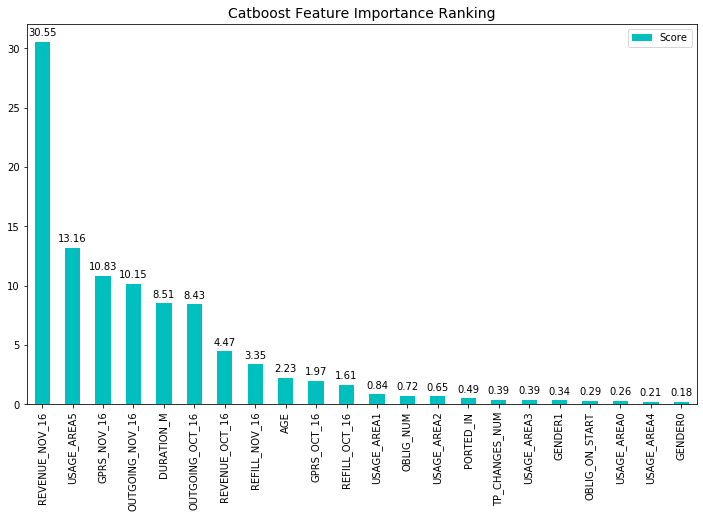

In [452]:
indexes = []
for a, b in enumerate(X.dtypes == 'object'):
    if b:
        indexes.append(a)
        
feature_score = cat_feature_importances(cat, X_train, y_train, indexes)

Here we can see that the differences in the importance of the features are great and data seems unbalanced. That's why maximum r2 score I got was not as big as I would like.

CatBoost algorithm is much more effective. Gradient Boosting makes better prediction than AdaBoost.